In [1]:
import json
import uproot
from XRootD import client
import xgboost as xgb
import os
import sys
sys.path.append("../../analysisTools/")
from skimmerTools import Skimmer
import coffea
import coffea.util as util
import numpy as np
import awkward as ak
import time
import h5py

### Run Skimmers on skimmed ntuples with preselections, produce h5 files for BDT input

In [2]:
outdir = "./h5/"
os.system(f"mkdir -p {outdir}")

0

In [3]:
def write_h5(data,fname):
    with h5py.File(fname,'w') as f:
        for k in data.keys():
            arr = data[k].value
            if type(arr) == np.ma.core.MaskedArray:
                arr = arr.data
            f.create_dataset(k,data=arr)

In [4]:
suffix = "_TrueVertexForSignal"

In [5]:
sample_json_dir = '../../configs/sample_configs/'
jsons = [f for f in os.listdir(sample_json_dir) if ".json" in f]

signal_list = [ samp.split('.')[0] for samp in jsons if "skimmed_sig_v2_egamma_hadd_2018_aEM" in samp ]
print(signal_list)

bkg_list = [ samp.split('.')[0] for samp in jsons if "skimmed_bkg" in samp ]
print(bkg_list)

['skimmed_sig_v2_egamma_hadd_2018_aEM']
['skimmed_bkg_2018_DY', 'skimmed_bkg_2018_Diboson', 'skimmed_bkg_2018_QCD_TuneCP5_PSWeights', 'skimmed_bkg_2018_TTJetsDiLept', 'skimmed_bkg_2018_Top', 'skimmed_bkg_2018_Triboson', 'skimmed_bkg_2018_WJets', 'skimmed_bkg_2018_ZJets']


In [6]:
for samp in signal_list:
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{sample_json_dir}/{samp}.json")
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_sig_v2_egamma_hadd_2018_aEM


Output()

Output()

Completed in 1.48 min



In [ ]:
for samp in bkg_list:
    if 'TTJetsDiLept' in samp: # currently not available ntuples
        continue
    
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{sample_json_dir}/{samp}.json")
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

## BDT

In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [8]:
h5_dir = "./h5/"
suffix = "_TrueVertexForSignal"
#suffix = "_Chi2VertexForSignal."

sig_files = [f for f in os.listdir(h5_dir) if suffix in f and 'sig' in f]
bkg_files = [f for f in os.listdir(h5_dir) if suffix in f and 'bkg' in f]

variables = ['lead_jet_pt','lead_jet_eta','minJetMETdPhi','jetMETdPhi',
             'sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy',
             'vxy_signif']

sig_data = []

sig_xsec_norm = []
sig_point = {'m1':[], 'delta':[], 'ctau':[]}

for sf in sig_files:
    with h5py.File(f'{h5_dir}/{sf}',"r") as fin:
        entries = len(fin['wgt'])
        
        match = fin["sel_vtx_match"][()]
        mask = match==2

        entries_genMatched = sum(mask)
        print(f'Signal events {entries} -> {entries_genMatched} after gen matching (raw counts)\n')
        
        sig_data.append(np.concatenate([fin[v][()][mask].reshape(-1,1) for v in variables],axis=1))
        sig_xsec_norm.append(fin['wgt_norm'][()][mask])
        
        sig_point['m1'].append(fin['m1'][()][mask])
        sig_point['delta'].append(fin['delta'][()][mask])
        sig_point['ctau'].append(fin['ctau'][()][mask])

sig_data = np.concatenate(sig_data,axis=0)
sig_xsec_norm = np.concatenate(sig_xsec_norm,axis=0)
sig_point['m1'] = np.concatenate(sig_point['m1'], axis=0)
sig_point['delta'] = np.concatenate(sig_point['delta'], axis=0)
sig_point['ctau'] = np.concatenate(sig_point['ctau'], axis=0)

nBkg = 0
bkg_data = []

bkg_xsec_norm = []

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])
        
        bkg_data.append(np.concatenate([fin[v][()].reshape(-1,1) for v in variables],axis=1))
        bkg_xsec_norm.append(fin['wgt_norm'][()])

bkg_xsec_norm = np.concatenate(bkg_xsec_norm,axis=0)


print(f'\nNumber of total background events (raw counts): {nBkg}')

bkg_data = np.concatenate(bkg_data,axis=0)

Signal events 8200 -> 8200 after gen matching (raw counts)

DY: 25
Diboson: 2317
QCD: 725
Top: 8467
Triboson: 310
WJets: 89850
ZJets: 125841

Number of total background events (raw counts): 227535


In [9]:
print(np.sum(np.array(sig_point['delta']) == 0.2))

2059


In [10]:
print(np.sum(np.array(sig_point['m1']) == 20))

1442


In [11]:
print(np.sum(np.array(sig_point['m1']) == 30.))

1822


In [12]:
print(np.sum(np.array(sig_point['m1']) == 40.))

1937


In [13]:
print(np.sum(np.array(sig_point['m1']) == 50.))

1210


In [14]:
print(np.sum(np.array(sig_point['ctau']) == 10.))

2999


In [15]:
print(np.sum(np.array(sig_point['ctau']) == 100.))

1481


In [16]:
len(sig_xsec_norm)

8200

### Background raw counts

In [17]:
bkg_raw = {}
nBkg = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])

        bkg_raw[process] = entries

DY: 25
Diboson: 2317
QCD: 725
Top: 8467
Triboson: 310
WJets: 89850
ZJets: 125841


### Cutflow counts (xsec weighted)

In [18]:
bkg_cts = {}
total_bkg_cts = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = sum(fin['wgt_norm'][()])
        print(f'{process}: {entries}')

        total_bkg_cts += entries
        
        bkg_cts[process] = entries

print(f'Total background counts (xsec weighted): {total_bkg_cts}')

DY: 2758.167739868164
Diboson: 577.1982629001141
QCD: 2948.0585146844387
Top: 987.1654803752899
Triboson: 7.3438074961304665
WJets: 31587.113397152105
ZJets: 15902.592084169271
Total background counts (xsec weighted): 54767.63928664551


### Reweighing factor = `wgt_norm` / `total_bkg_cts` * `nBkg`

Reweigh the background samples, such that after reweighting the total number of backgrounds (BDT sample size) are unchanged but the relative contributions of each sub-process within the BDT sample are physically correct.

In [19]:
sf = {}
xsec_norm = {}

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = fin['wgt_norm'][()] / total_bkg_cts * nBkg
        print(f'{process}: {entries}')

        sf[process] = entries
        xsec_norm[process] = fin['wgt_norm'][()]

DY: [ 596.21537446  596.21537446  596.21537446  596.21537446 7072.34514263
  100.08721033  100.08721033  100.08721033  100.08721033  100.08721033
  100.08721033  100.08721033  100.08721033  100.08721033  100.08721033
  100.08721033  100.08721033  100.08721033  100.08721033  100.08721033
  100.08721033  100.08721033  100.08721033  100.08721033  100.08721033]
Diboson: [0.89880776 0.89880776 0.89880776 ... 1.20928162 1.20928162 1.20928162]
QCD: [3.25839587e+01 3.25839587e+01 3.25839587e+01 3.25839587e+01
 3.25839587e+01 3.25839587e+01 3.25839587e+01 3.25839587e+01
 3.25839587e+01 3.25839587e+01 3.25839587e+01 3.25839587e+01
 3.25839587e+01 3.25839587e+01 3.25839587e+01 3.25839587e+01
 3.25839587e+01 3.25839587e+01 3.25839587e+01 3.25839587e+01
 3.25839587e+01 3.25839587e+01 3.25839587e+01 3.25839587e+01
 3.25839587e+01 3.25839587e+01 3.25839587e+01 3.25839587e+01
 3.25839587e+01 3.25839587e+01 3.25839587e+01 3.25839587e+01
 3.25839587e+01 3.25839587e+01 3.25839587e+01 3.25839587e+01
 3.25

**With the weight applied, the total bkg events are the same as raw counts, but the contribution of the relative xsec is considered now.**

In [20]:
total_weighted = 0

for process in sf.keys():
    print(f'{process}: {sum(sf[process])}')
    total_weighted += sum(sf[process])

print(total_weighted)

DY: 11458.950847105589
Diboson: 2398.000012401313
QCD: 12247.86172347568
Top: 4101.230168370923
Triboson: 30.51022940711409
WJets: 131230.297716209
ZJets: 66068.14382965055
227534.99452662014


In [21]:
nBkg

227535

In [22]:
# SF
bkg_sf = []
bkg_xsec_norm = []

for process in sf.keys():
    bkg_sf += list(sf[process])
    bkg_xsec_norm += list(xsec_norm[process])

#print(len(bkg_sf))

In [23]:
bkg_xsec_norm

[143.50896,
 143.50896,
 143.50896,
 143.50896,
 1702.3124,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 24.090977,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2163429,
 0.2

In [24]:
len(bkg_sf)

227535

### Train -- Bkg Reweighted

In [25]:
bkg_sf_arr = np.array(bkg_sf)
sig_sf_arr = np.ones(sig_data.shape[0])

In [26]:
len(sig_xsec_norm)

8200

In [27]:
len(sig_point['m1'])

8200

In [28]:
rng = np.random.default_rng(seed=438290)
random_state = rng.integers(0,100000,1)[0]

# 8-2 split of train/test set; shuffle the array of SFs accordingly
sig_train, sig_test = train_test_split(sig_data,train_size=0.8,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=0.8, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=0.8, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=0.8, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=0.8, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=0.8, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=0.8,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=0.8, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=0.8, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [37]:
test_ctau[np.where(y_test == 0)]

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
test_xsec_norm[np.where(y_test == 1)].min()

0.00019884697

In [31]:
sig_xsec_norm.min()

0.00019783861

In [32]:
len(test_xsec_norm)

47147

In [48]:
bst = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, objective='binary:logistic')

# fit model
bst.fit(train, y_train, sample_weight=train_sf)
#bst.fit(train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='binary:logistic', predictor=None, ...)

In [50]:
# make predictions
preds = bst.predict(test)

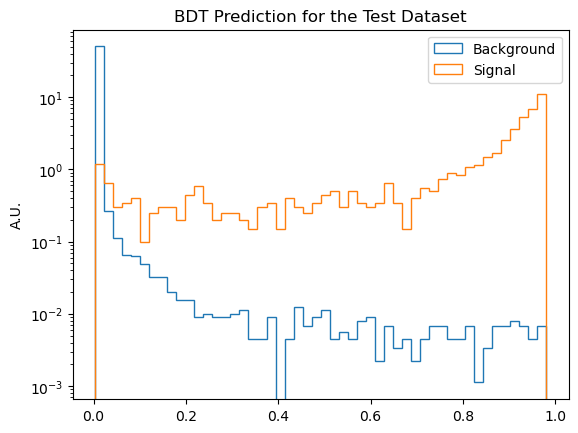

In [51]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset')

plt.ylabel('A.U.')
#plt.savefig('plots/BDTscore.png')
plt.yscale('log')

[Text(0, 0, 'jetMETdPhi'),
 Text(0, 1, 'lead_jet_eta'),
 Text(0, 2, 'minJetMETdPhi'),
 Text(0, 3, 'lead_jet_pt'),
 Text(0, 4, 'vxy_signif'),
 Text(0, 5, 'sel_vtx_chi2'),
 Text(0, 6, 'sel_vtx_m'),
 Text(0, 7, 'sel_vtx_METdPhi'),
 Text(0, 8, 'sel_vtx_dR'),
 Text(0, 9, 'sel_vtx_minDxy')]

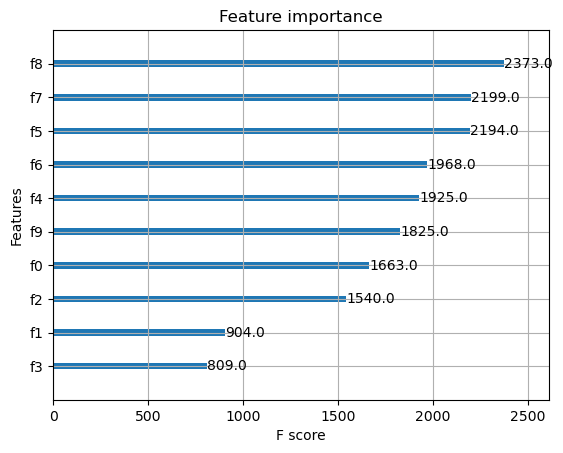

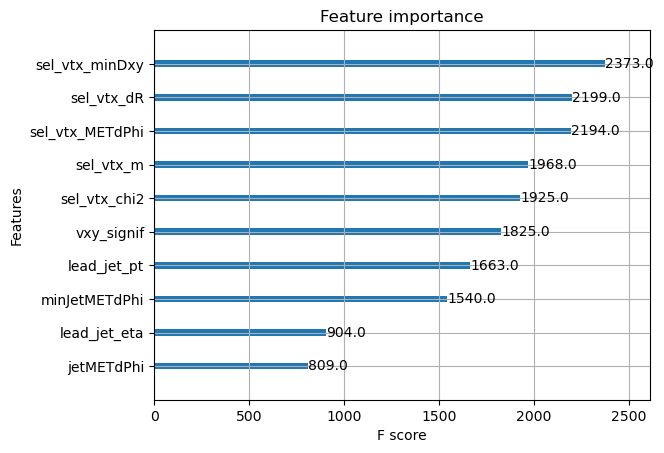

In [52]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(bst)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(bst).set_yticklabels(relabel)
#plt.savefig('plots/importance_bst_weighted.png', bbox_inches = "tight")

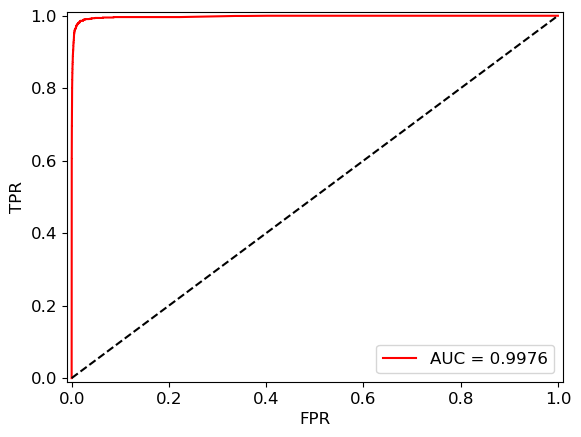

In [53]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

### Save and load

In [54]:
bst.save_model('BDT_v1.json')

In [58]:
trained_model = xgb.XGBRegressor()
trained_model.load_model("BDT_v1.json")

In [59]:
prediction = trained_model.predict(test)

In [84]:
bkg_test[0:10]

array([[ 4.9017175e+02,  1.8950319e+00,  2.1417558e-01,  3.0993235e+00,
         6.5662460e+01,  2.4145892e+00,  2.6795712e+00,  2.0658782e+00,
         3.6522907e-03,  1.3079131e+01],
       [ 1.7538356e+02, -1.7371274e+00,  3.0586960e+00,  3.0969579e+00,
         2.6702450e+01,  2.9471009e+00,  8.5993338e+00,  2.9908478e+00,
         1.2504302e-02,  9.2921265e+01],
       [ 3.0294547e+02, -4.3829229e-01,  1.2412190e+00,  2.8871400e+00,
         3.2884834e+00,  8.8870376e-02,  5.0120041e+01,  4.4650397e+00,
         6.2740077e-03,  4.0233436e+00],
       [ 3.9061588e+02,  2.0627849e+00,  1.2308359e-02,  3.1200850e+00,
         1.6724208e+02,  7.5436342e-01,  2.9145224e+00,  2.1057401e+00,
         2.8273347e-03,  5.6712521e+01],
       [ 5.0482291e+02,  5.6722140e-01,  4.7341958e-02,  3.1078031e+00,
         2.3960084e-02,  1.5211449e+00,  5.6603322e+00,  3.1506627e+00,
         5.9435531e-03,  1.2337003e+00],
       [ 2.6078311e+02,  3.9936128e-01,  2.9678860e+00,  2.9678860e+00,
   

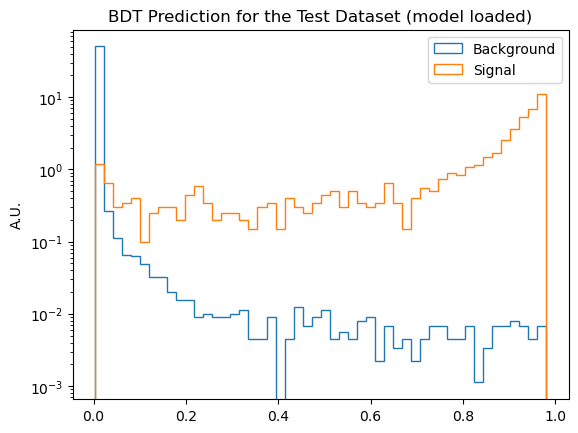

In [60]:
bins = 50

h,bins,_ = plt.hist(prediction[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(prediction[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset (model loaded)')

plt.ylabel('A.U.')
#plt.savefig('plots/BDTscore.png')
plt.yscale('log')

[Text(0, 0, 'jetMETdPhi'),
 Text(0, 1, 'lead_jet_eta'),
 Text(0, 2, 'minJetMETdPhi'),
 Text(0, 3, 'lead_jet_pt'),
 Text(0, 4, 'vxy_signif'),
 Text(0, 5, 'sel_vtx_chi2'),
 Text(0, 6, 'sel_vtx_m'),
 Text(0, 7, 'sel_vtx_METdPhi'),
 Text(0, 8, 'sel_vtx_dR'),
 Text(0, 9, 'sel_vtx_minDxy')]

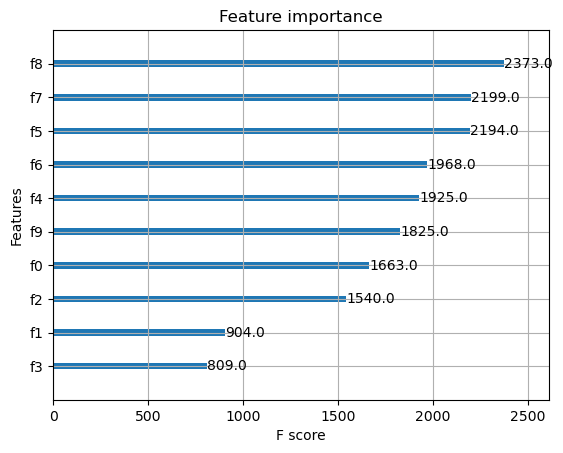

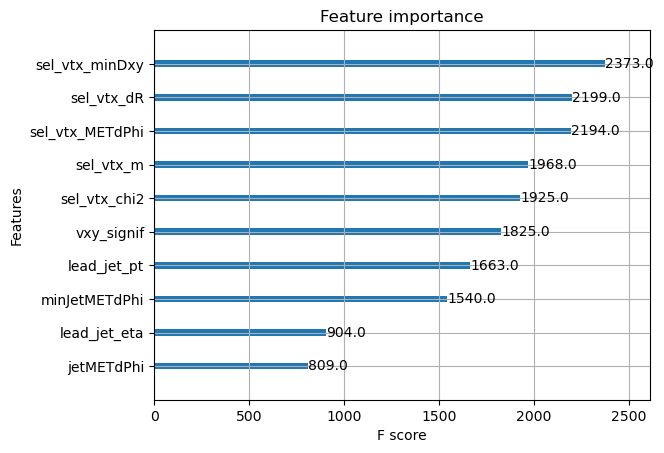

In [63]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(trained_model)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(trained_model).set_yticklabels(relabel)
#plt.savefig('plots/importance_bst_weighted.png', bbox_inches = "tight")

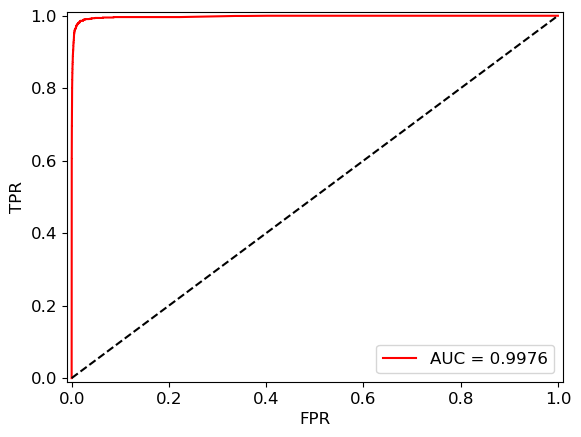

In [62]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc = roc_auc_score(y_test, prediction)
precision, recall, thresholds2 = precision_recall_curve(y_test, prediction)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

### WP

In [418]:
thresholds

array([1.9971712 , 0.9971711 , 0.9958318 , ..., 0.00336299, 0.0033629 ,
       0.00335931], dtype=float32)

In [419]:
tpr

array([0.00000000e+00, 6.09756098e-04, 7.31707317e-03, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [420]:
tpr_WP = {'tight': 0.7, 'medium': 0.8, 'loose': 0.9}
thres_WP = {'tight': 0, 'medium': 0, 'loose': 0}

In [421]:
epsilon = 0.01

for wp in tpr_WP.keys():    
    idx = np.where((tpr > tpr_WP[wp] - epsilon) & (tpr < tpr_WP[wp] + epsilon))
    
    thres_WP[wp] = thresholds[idx].mean()

    print(f'{wp} threshold: {thres_WP[wp]}')

tight threshold: 0.9208323955535889
medium threshold: 0.8212189674377441
loose threshold: 0.4034811556339264


### S/B (all signal points combined)

In [422]:
# BDT scores for the signal
nPass_sig = {'tight': 0, 'medium': 0, 'loose': 0}
nPass_bkg = {'tight': 0, 'medium': 0, 'loose': 0}

s_over_b = {'tight': 0, 'medium': 0, 'loose': 0}

for wp in nPass_sig.keys():
    nPass_sig[wp] = np.sum(preds[np.where(y_test==1)] > thres_WP[wp])
    nPass_bkg[wp] = np.sum(preds[np.where(y_test==0)] > thres_WP[wp])
    
    print(f'\n{wp} pass')
    print(f'TPR: {nPass_sig[wp]} / {len(preds[np.where(y_test==1)])} = {nPass_sig[wp]/len(preds[np.where(y_test==1)])}')
    print(f'FPR: {nPass_bkg[wp]} / {len(preds[np.where(y_test==0)])} = {nPass_bkg[wp]/len(preds[np.where(y_test==0)])}')
    
    s_over_b[wp] = nPass_sig[wp] / nPass_bkg[wp]
    print(f'S/B = {s_over_b[wp]}')


tight pass
TPR: 1144 / 1640 = 0.697560975609756
FPR: 33 / 45507 = 0.0007251631617113851
S/B = 34.666666666666664

medium pass
TPR: 1315 / 1640 = 0.801829268292683
FPR: 65 / 45507 = 0.0014283516821587887
S/B = 20.23076923076923

loose pass
TPR: 1469 / 1640 = 0.8957317073170732
FPR: 153 / 45507 = 0.003362120113389149
S/B = 9.601307189542483


In [432]:
# xsec weighted S/B

nPass_sig_xsec_norm = {'tight': 0, 'medium': 0, 'loose': 0}
nPass_bkg_xsec_norm = {'tight': 0, 'medium': 0, 'loose': 0}

s_over_b_xsec_norm = {'tight': 0, 'medium': 0, 'loose': 0}

for wp in nPass_sig.keys():
    nPass_sig_xsec_norm[wp] = np.sum(test_xsec_norm[np.where(preds[np.where(y_test==1)] > thres_WP[wp])])
    nPass_bkg_xsec_norm[wp] = np.sum(test_xsec_norm[np.where(preds[np.where(y_test==0)] > thres_WP[wp])])
    
    print(f'\n{wp} pass')
    print(f'TPR: {nPass_sig_xsec_norm[wp]} / {np.sum(test_xsec_norm[np.where(y_test==1)])} = {nPass_sig_xsec_norm[wp]/np.sum(test_xsec_norm[np.where(y_test==1)])}')
    print(f'FPR: {nPass_bkg_xsec_norm[wp]} / {np.sum(test_xsec_norm[np.where(y_test==0)])} = {nPass_bkg_xsec_norm[wp]/np.sum(test_xsec_norm[np.where(y_test==0)])}')
    
    s_over_b_xsec_norm[wp] = nPass_sig_xsec_norm[wp] / nPass_bkg_xsec_norm[wp]
    print(f'S/B = {s_over_b_xsec_norm[wp]}')


tight pass
TPR: 362.89312744140625 / 4607.78515625 = 0.07875651866197586
FPR: 8.356795310974121 / 10205.708984375 = 0.0008188353385776281
S/B = 43.4249153137207

medium pass
TPR: 422.35150146484375 / 4607.78515625 = 0.09166041761636734
FPR: 18.277605056762695 / 10205.708984375 = 0.0017909196903929114
S/B = 23.107595443725586

loose pass
TPR: 460.30194091796875 / 4607.78515625 = 0.09989657253026962
FPR: 38.09037780761719 / 10205.708984375 = 0.0037322617135941982
S/B = 12.084467887878418


In [433]:
# BDT scores for the signal
m1 = 50.
delta = 0.2
ctau = 100.

nPass_sig_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
nPass_bkg_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}

s_over_b_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}

for wp in nPass_sig.keys():
    sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
    bkg_idx = np.where(y_test==0)
    
    nPass_sig_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
    nPass_bkg_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])
    
    print(f'\n{wp} pass')
    print(f'TPR: {nPass_sig_sigpoint[wp]} / {len(preds[sig_idx])} = {nPass_sig_sigpoint[wp]/len(preds[sig_idx])}')
    print(f'FPR: {nPass_bkg_sigpoint[wp]} / {len(preds[bkg_idx])} = {nPass_bkg_sigpoint[wp]/len(preds[bkg_idx])}')
    
    s_over_b_sigpoint[wp] = nPass_sig_sigpoint[wp] / nPass_bkg_sigpoint[wp]
    print(f'S/B = {s_over_b_sigpoint[wp]}')


tight pass
TPR: 39 / 49 = 0.7959183673469388
FPR: 33 / 45507 = 0.0007251631617113851
S/B = 1.1818181818181819

medium pass
TPR: 40 / 49 = 0.8163265306122449
FPR: 65 / 45507 = 0.0014283516821587887
S/B = 0.6153846153846154

loose pass
TPR: 43 / 49 = 0.8775510204081632
FPR: 153 / 45507 = 0.003362120113389149
S/B = 0.28104575163398693


### S/B per signal point

In [439]:
# xsec weighted S/B
tpr_raw = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
            '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
          }

s_sqrtB_raw = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
                '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
              }

for ctau in [1., 10., 100.]:
    for delta in [0.1, 0.2]:
        for m1 in [10., 20., 30., 40., 50.]:
            nPass_sig_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            nPass_bkg_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            s_over_b_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            for wp in nPass_sig.keys():
                sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
                bkg_idx = np.where(y_test==0)
                
                nPass_sig_raw_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
                nPass_bkg_raw_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])
                
                s_over_b_raw_sigpoint[wp] = nPass_sig_raw_sigpoint[wp] / np.sqrt(nPass_bkg_raw_sigpoint[wp])

                print(f'm1 = {m1}, delta = {delta}, ct = {ctau}')
                print(f'TPR: {nPass_sig_raw_sigpoint[wp]} / {len(sig_idx[0])} = {nPass_sig_raw_sigpoint[wp]/len(sig_idx[0])}')
                
                s_sqrtB_raw[f'{str(delta)}'][f'ct-{int(ctau)}'][wp].append(s_over_b_raw_sigpoint[wp])

m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 63 / 110 = 0.5727272727272728
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 81 / 110 = 0.7363636363636363
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 99 / 110 = 0.9
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 71 / 122 = 0.5819672131147541
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 92 / 122 = 0.7540983606557377
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 107 / 122 = 0.8770491803278688
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 104 / 158 = 0.6582278481012658
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 126 / 158 = 0.7974683544303798
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 139 / 158 = 0.879746835443038
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 92 / 149 = 0.6174496644295302
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 105 / 149 = 0.7046979865771812
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 121 / 149 = 0.8120805369127517
m1 = 50.0, delta = 0.1, ct = 1.0
TPR: 16 / 30 = 0.5333333333333333
m1 = 50.0, delta = 0.1, ct = 1.0
TPR: 21 / 30 = 0.7
m1 = 50.0, delta = 0.1, ct = 1.0
TPR: 22 / 30 = 0.7333333333333333
m1 = 10.

/tmp/ipykernel_23615/2915402270.py:28: RuntimeWarning: invalid value encountered in scalar divide
  print(f'TPR: {nPass_sig_raw_sigpoint[wp]} / {len(sig_idx[0])} = {nPass_sig_raw_sigpoint[wp]/len(sig_idx[0])}')


In [440]:
len(sig_idx[0])

49

In [441]:
tpr_raw

{'0.1': {'ct-1': {'tight': [], 'medium': [], 'loose': []},
  'ct-10': {'tight': [], 'medium': [], 'loose': []},
  'ct-100': {'tight': [], 'medium': [], 'loose': []}},
 '0.2': {'ct-1': {'tight': [], 'medium': [], 'loose': []},
  'ct-10': {'tight': [], 'medium': [], 'loose': []},
  'ct-100': {'tight': [], 'medium': [], 'loose': []}}}

In [442]:
# xsec weighted S/B
s_sqrtB = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
            '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
          }

for ctau in [1., 10., 100.]:
    for delta in [0.1, 0.2]:
        for m1 in [10., 20., 30., 40., 50.]:
            nPass_sig_xsec_norm_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            nPass_bkg_xsec_norm_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            s_over_b_xsec_norm_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            for wp in nPass_sig.keys():
                sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
                bkg_idx = np.where(y_test==0)
                
                nPass_sig_xsec_norm_sigpoint[wp] = np.sum(test_xsec_norm[np.where(preds[sig_idx] > thres_WP[wp])])
                nPass_bkg_xsec_norm_sigpoint[wp] = np.sum(test_xsec_norm[np.where(preds[bkg_idx] > thres_WP[wp])])
                
                print(f'\n{wp} pass: m1 = {m1}, delta = {delta}, ctau = {ctau}')
                print(f'TPR: {nPass_sig_xsec_norm_sigpoint[wp]} / {np.sum(test_xsec_norm[sig_idx])} = {nPass_sig_xsec_norm_sigpoint[wp]/np.sum(test_xsec_norm[sig_idx])}')
                print(f'FPR: {nPass_bkg_xsec_norm_sigpoint[wp]} / {np.sum(test_xsec_norm[bkg_idx])} = {nPass_bkg_xsec_norm_sigpoint[wp]/np.sum(test_xsec_norm[bkg_idx])}')
                
                s_over_b_xsec_norm_sigpoint[wp] = nPass_sig_xsec_norm_sigpoint[wp] / np.sqrt(nPass_bkg_xsec_norm_sigpoint[wp])
                print(f'S/sqrt(B) = {s_over_b_xsec_norm_sigpoint[wp]}')
        
                s_sqrtB[f'{str(delta)}'][f'ct-{int(ctau)}'][wp].append(s_over_b_xsec_norm_sigpoint[wp])


tight pass: m1 = 10.0, delta = 0.1, ctau = 1.0
TPR: 17.395219802856445 / 530.2313842773438 = 0.032806847244501114
FPR: 8.356795310974121 / 10205.708984375 = 0.0008188353385776281
S/sqrt(B) = 6.017416000366211

medium pass: m1 = 10.0, delta = 0.1, ctau = 1.0
TPR: 24.573911666870117 / 530.2313842773438 = 0.04634563624858856
FPR: 18.277605056762695 / 10205.708984375 = 0.0017909196903929114
S/sqrt(B) = 5.74797248840332

loose pass: m1 = 10.0, delta = 0.1, ctau = 1.0
TPR: 30.23887062072754 / 530.2313842773438 = 0.05702957510948181
FPR: 38.09037780761719 / 10205.708984375 = 0.0037322617135941982
S/sqrt(B) = 4.899569511413574

tight pass: m1 = 20.0, delta = 0.1, ctau = 1.0
TPR: 13.060842514038086 / 430.9218444824219 = 0.030309075489640236
FPR: 8.356795310974121 / 10205.708984375 = 0.0008188353385776281
S/sqrt(B) = 4.51805305480957

medium pass: m1 = 20.0, delta = 0.1, ctau = 1.0
TPR: 21.996654510498047 / 430.9218444824219 = 0.051045577973127365
FPR: 18.277605056762695 / 10205.708984375 = 0.0

/tmp/ipykernel_23615/3424959266.py:22: RuntimeWarning: invalid value encountered in scalar divide
  print(f'TPR: {nPass_sig_xsec_norm_sigpoint[wp]} / {np.sum(test_xsec_norm[sig_idx])} = {nPass_sig_xsec_norm_sigpoint[wp]/np.sum(test_xsec_norm[sig_idx])}')


In [443]:
s_sqrtB

{'0.1': {'ct-1': {'tight': [6.017416,
    4.518053,
    9.330421,
    9.891339,
    0.85954434],
   'medium': [5.7479725, 5.145138, 8.235293, 7.317819, 0.9203506],
   'loose': [4.8995695, 5.0409718, 6.291403, 5.8429856, 0.7280211]},
  'ct-10': {'tight': [2.8468933, 2.5981667, 10.148478, 8.065085, 2.0462337],
   'medium': [2.1088767, 1.8374139, 7.123308, 6.950701, 1.3836156],
   'loose': [1.8106663, 1.3932118, 5.4031014, 5.0993805, 0.97232413]},
  'ct-100': {'tight': [1.5048732, 1.6377624, 2.2751272, 6.4973035, 1.9196267],
   'medium': [1.2480332, 1.107417, 1.7053993, 4.4739194, 1.559149],
   'loose': [0.903762, 0.7717722, 1.2718328, 3.103785, 1.1185642]}},
 '0.2': {'ct-1': {'tight': [1.4434804, 1.2928505, 1.1715648, 0.0, 0.45988292],
   'medium': [1.2354938, 1.0782182, 1.0209616, 0.0, 0.4980083],
   'loose': [0.9549378, 1.202126, 0.8834023, 0.0, 0.36059803]},
  'ct-10': {'tight': [1.6967262, 2.950549, 1.2914442, 1.5566802, 4.4187293],
   'medium': [1.1497751, 2.396949, 0.9538383, 1.103

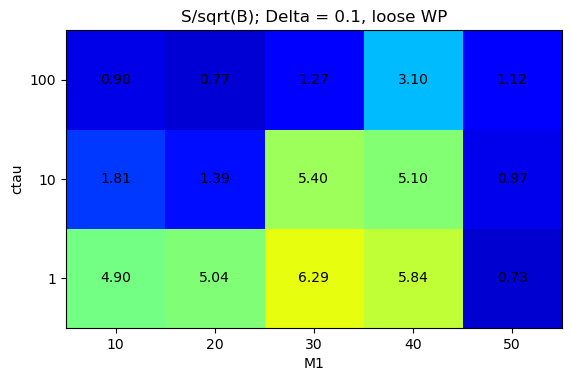

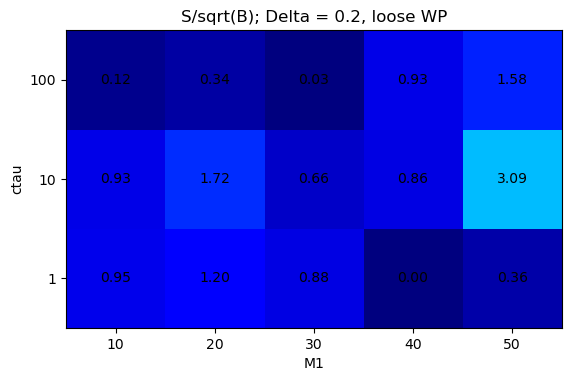

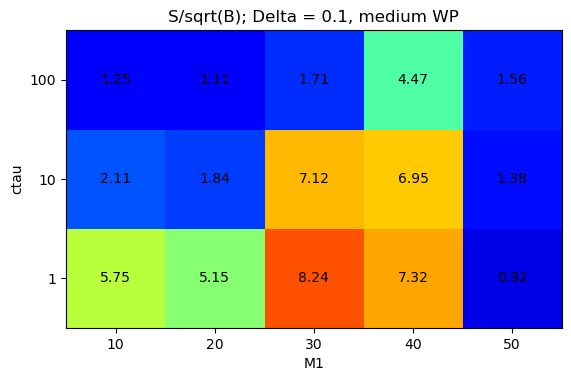

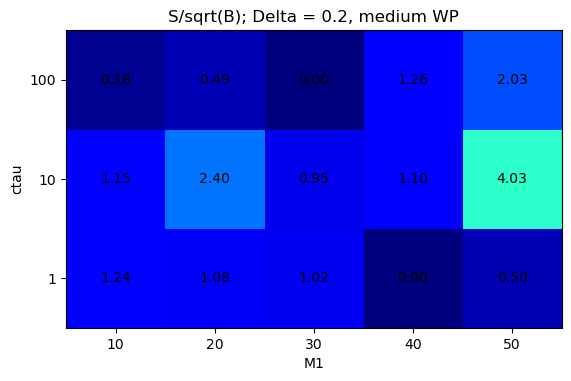

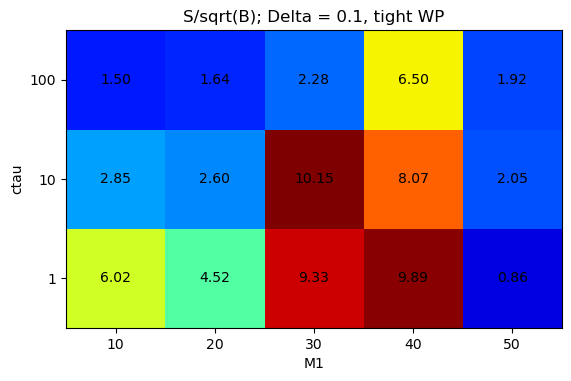

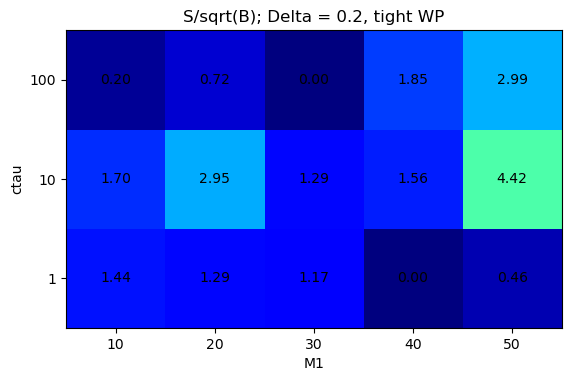

In [444]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([s_sqrtB[delta]['ct-1'][wp],\
                        s_sqrtB[delta]['ct-10'][wp],\
                        s_sqrtB[delta]['ct-100'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=10)
        
        plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'S/sqrt(B); Delta = {delta}, {wp} WP')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,5), [10, 20, 30, 40, 50])
        plt.yticks(range(0,3), [1, 10, 100])
        
        plt.gca().invert_yaxis()
        
        plt.show()

### S/B on half dataset (not just 20%)

In [445]:
train_size = 0.7

sig_train, sig_test = train_test_split(sig_data,train_size=train_size,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=train_size, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=train_size, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=train_size, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=train_size, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=train_size, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=train_size,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=train_size, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=train_size, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

#perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

#perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [446]:
preds = bst.predict(test)

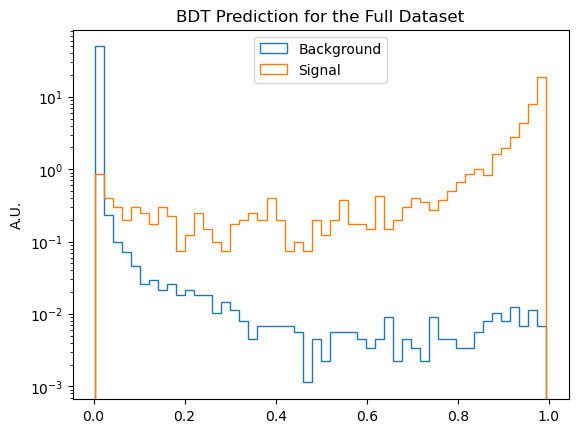

In [447]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Full Dataset')

plt.ylabel('A.U.')
#plt.savefig('plots/BDTscore.png')
plt.yscale('log')

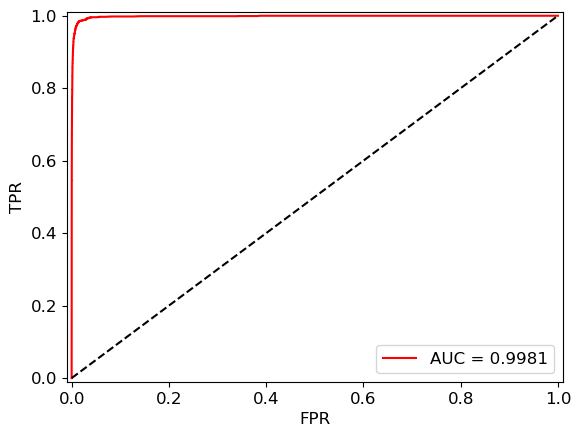

In [448]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

In [449]:
# xsec weighted S/B
tpr = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
        '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
      }

s_sqrtB = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
            '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
          }

for ctau in [1., 10., 100.]:
    for delta in [0.1, 0.2]:
        for m1 in [10., 20., 30., 40., 50.]:
            nPass_sig_xsec_norm_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            nPass_bkg_xsec_norm_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            s_over_b_xsec_norm_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            for wp in nPass_sig.keys():
                sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
                bkg_idx = np.where(y_test==0)
                
                nPass_sig_xsec_norm_sigpoint[wp] = np.sum(test_xsec_norm[np.where(preds[sig_idx] > thres_WP[wp])])
                nPass_bkg_xsec_norm_sigpoint[wp] = np.sum(test_xsec_norm[np.where(preds[bkg_idx] > thres_WP[wp])])
                
                print(f'\n{wp} pass: m1 = {m1}, delta = {delta}, ctau = {ctau}')
                print(f'TPR: {nPass_sig_xsec_norm_sigpoint[wp]} / {np.sum(test_xsec_norm[sig_idx])} = {nPass_sig_xsec_norm_sigpoint[wp]/np.sum(test_xsec_norm[sig_idx])}')
                print(f'FPR: {nPass_bkg_xsec_norm_sigpoint[wp]} / {np.sum(test_xsec_norm[bkg_idx])} = {nPass_bkg_xsec_norm_sigpoint[wp]/np.sum(test_xsec_norm[bkg_idx])}')
                
                s_over_b_xsec_norm_sigpoint[wp] = nPass_sig_xsec_norm_sigpoint[wp] / np.sqrt(nPass_bkg_xsec_norm_sigpoint[wp])
                print(f'S/sqrt(B) = {s_over_b_xsec_norm_sigpoint[wp]}')

                s_sqrtB[f'{str(delta)}'][f'ct-{int(ctau)}'][wp].append(s_over_b_xsec_norm_sigpoint[wp])


tight pass: m1 = 10.0, delta = 0.1, ctau = 1.0
TPR: 25.627912521362305 / 785.9005737304688 = 0.03260961174964905
FPR: 8.392784118652344 / 10015.3271484375 = 0.0008379939827136695
S/sqrt(B) = 8.846270561218262

medium pass: m1 = 10.0, delta = 0.1, ctau = 1.0
TPR: 40.82603454589844 / 785.9005737304688 = 0.05194809287786484
FPR: 23.77488899230957 / 10015.3271484375 = 0.0023738504387438297
S/sqrt(B) = 8.372940063476562

loose pass: m1 = 10.0, delta = 0.1, ctau = 1.0
TPR: 47.6378173828125 / 785.9005737304688 = 0.060615576803684235
FPR: 47.83759689331055 / 10015.3271484375 = 0.004776438698172569
S/sqrt(B) = 6.887588024139404

tight pass: m1 = 20.0, delta = 0.1, ctau = 1.0
TPR: 35.346282958984375 / 635.715087890625 = 0.05560082569718361
FPR: 8.392784118652344 / 10015.3271484375 = 0.0008379939827136695
S/sqrt(B) = 12.200868606567383

medium pass: m1 = 20.0, delta = 0.1, ctau = 1.0
TPR: 44.00254821777344 / 635.715087890625 = 0.06921740621328354
FPR: 23.77488899230957 / 10015.3271484375 = 0.002

/tmp/ipykernel_23615/1515096932.py:26: RuntimeWarning: invalid value encountered in scalar divide
  print(f'TPR: {nPass_sig_xsec_norm_sigpoint[wp]} / {np.sum(test_xsec_norm[sig_idx])} = {nPass_sig_xsec_norm_sigpoint[wp]/np.sum(test_xsec_norm[sig_idx])}')


In [450]:
s_sqrtB

{'0.1': {'ct-1': {'tight': [8.846271,
    12.200869,
    14.784755,
    15.530307,
    3.5139077],
   'medium': [8.37294, 9.0244055, 11.393592, 10.503942, 2.3545399],
   'loose': [6.887588, 6.993763, 8.564602, 8.169281, 1.8594917]},
  'ct-10': {'tight': [7.6416645, 7.968842, 15.314137, 14.183494, 4.9729633],
   'medium': [4.9550343, 4.7405505, 9.316729, 9.29662, 2.9546704],
   'loose': [3.8266077, 3.6716015, 7.772909, 7.801524, 2.0966384]},
  'ct-100': {'tight': [4.09078, 3.472744, 6.036416, 10.554942, 4.6432333],
   'medium': [2.742202, 2.3071177, 3.6378982, 7.4312124, 3.0782928],
   'loose': [2.1815841, 1.6762805, 2.574421, 5.315354, 2.2836978]}},
 '0.2': {'ct-1': {'tight': [2.9758747, 4.1521792, 2.7786481, 0.0, 0.9364671],
   'medium': [2.005641, 3.4162683, 1.9906259, 0.0, 0.8231616],
   'loose': [2.253984, 2.602316, 2.263265, 0.0, 0.74483055]},
  'ct-10': {'tight': [2.520076, 6.8073835, 4.330273, 4.6914945, 9.048976],
   'medium': [1.5034505, 4.131324, 2.65109, 2.8690958, 5.735607]

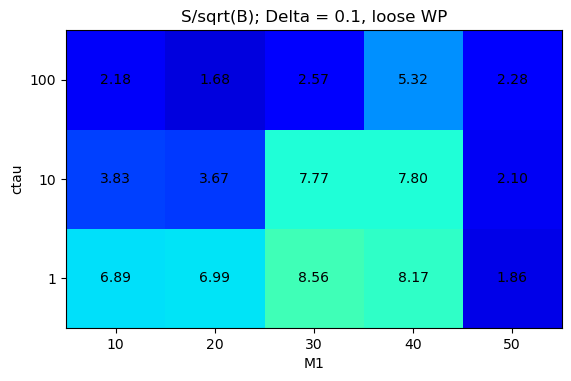

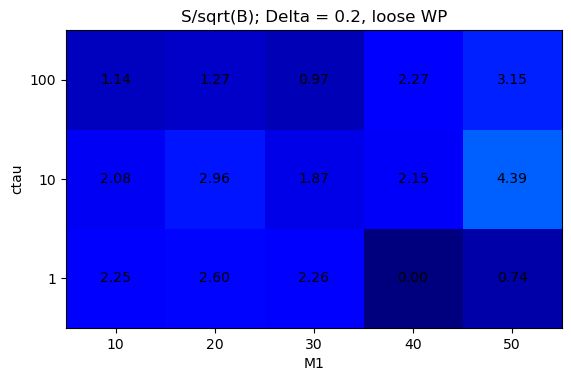

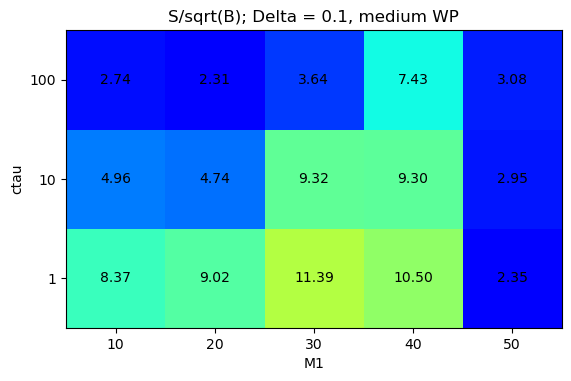

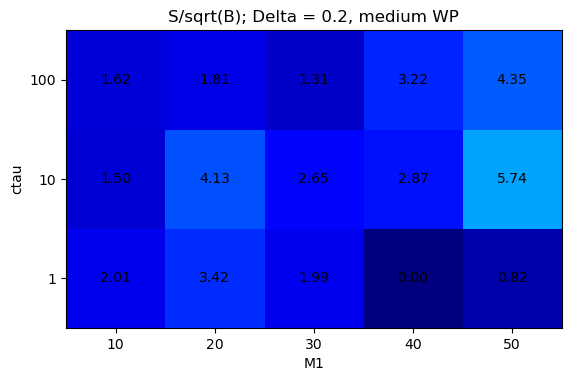

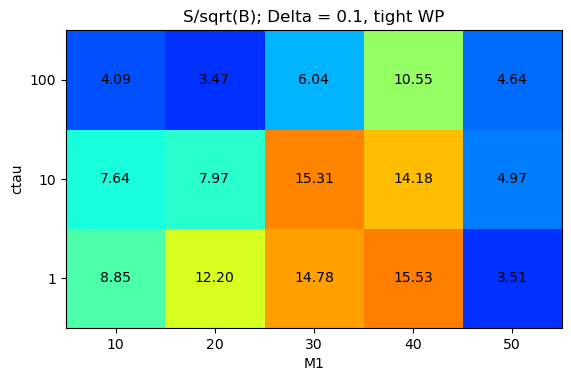

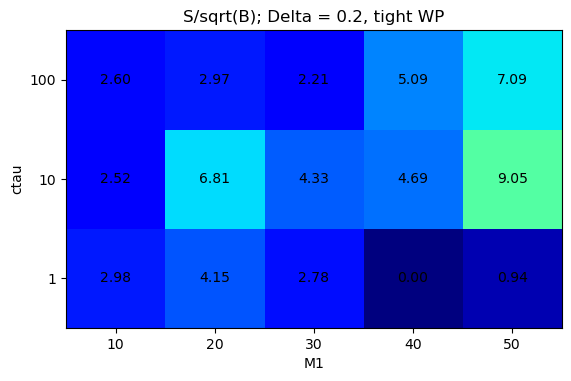

In [534]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([s_sqrtB[delta]['ct-1'][wp],\
                        s_sqrtB[delta]['ct-10'][wp],\
                        s_sqrtB[delta]['ct-100'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=20)
        
        plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'S/sqrt(B); Delta = {delta}, {wp} WP')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,5), [10, 20, 30, 40, 50])
        plt.yticks(range(0,3), [1, 10, 100])
        
        plt.gca().invert_yaxis()
        
        plt.show()

In [455]:
# raw
tpr_raw = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
            '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
          }

s_sqrtB_raw = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
                '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
              }

for ctau in [1., 10., 100.]:
    for delta in [0.1, 0.2]:
        for m1 in [10., 20., 30., 40., 50.]:
            nPass_sig_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            nPass_bkg_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            s_over_b_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            for wp in nPass_sig.keys():
                sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
                bkg_idx = np.where(y_test==0)
                
                nPass_sig_raw_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
                nPass_bkg_raw_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])
                
                s_over_b_raw_sigpoint[wp] = nPass_sig_raw_sigpoint[wp] / np.sqrt(nPass_bkg_raw_sigpoint[wp])

                print(f'{wp}: m1 = {m1}, delta = {delta}, ct = {ctau}')
                tpr = nPass_sig_raw_sigpoint[wp]/len(sig_idx[0])
                #print(f'TPR: {nPass_sig_raw_sigpoint[wp]} / {len(sig_idx[0])} = {tpr}')
                
                s_sqrtB_raw[f'{str(delta)}'][f'ct-{int(ctau)}'][wp].append(s_over_b_raw_sigpoint[wp])
                tpr_raw[f'{str(delta)}'][f'ct-{int(ctau)}'][wp].append(tpr)

tight: m1 = 10.0, delta = 0.1, ct = 1.0
medium: m1 = 10.0, delta = 0.1, ct = 1.0
loose: m1 = 10.0, delta = 0.1, ct = 1.0
tight: m1 = 20.0, delta = 0.1, ct = 1.0
medium: m1 = 20.0, delta = 0.1, ct = 1.0
loose: m1 = 20.0, delta = 0.1, ct = 1.0
tight: m1 = 30.0, delta = 0.1, ct = 1.0
medium: m1 = 30.0, delta = 0.1, ct = 1.0
loose: m1 = 30.0, delta = 0.1, ct = 1.0
tight: m1 = 40.0, delta = 0.1, ct = 1.0
medium: m1 = 40.0, delta = 0.1, ct = 1.0
loose: m1 = 40.0, delta = 0.1, ct = 1.0
tight: m1 = 50.0, delta = 0.1, ct = 1.0
medium: m1 = 50.0, delta = 0.1, ct = 1.0
loose: m1 = 50.0, delta = 0.1, ct = 1.0
tight: m1 = 10.0, delta = 0.2, ct = 1.0
medium: m1 = 10.0, delta = 0.2, ct = 1.0
loose: m1 = 10.0, delta = 0.2, ct = 1.0
tight: m1 = 20.0, delta = 0.2, ct = 1.0
medium: m1 = 20.0, delta = 0.2, ct = 1.0
loose: m1 = 20.0, delta = 0.2, ct = 1.0
tight: m1 = 30.0, delta = 0.2, ct = 1.0
medium: m1 = 30.0, delta = 0.2, ct = 1.0
loose: m1 = 30.0, delta = 0.2, ct = 1.0
tight: m1 = 40.0, delta = 0.2, c

/tmp/ipykernel_23615/2218645647.py:28: RuntimeWarning: invalid value encountered in scalar divide
  tpr = nPass_sig_raw_sigpoint[wp]/len(sig_idx[0])


Text(0.5, 1.0, 'S/sqrt(B), Delta = 0.1, BDT Tight WP')

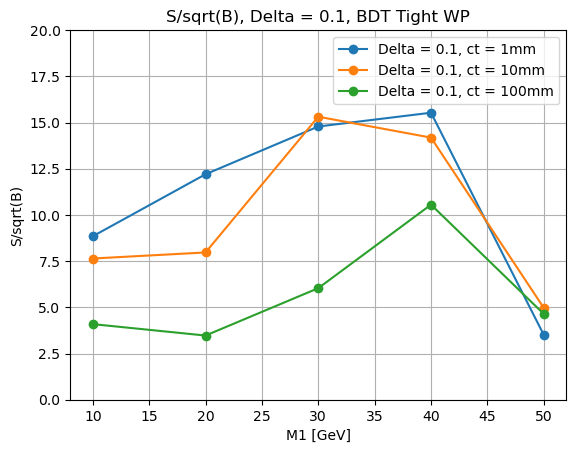

In [483]:
x_arr = [10,20,30,40,50]
y_arr_1 = s_sqrtB['0.1']['ct-1']['tight']
y_arr_2 = s_sqrtB['0.1']['ct-10']['tight']
y_arr_3 = s_sqrtB['0.1']['ct-100']['tight']

plt.plot(x_arr, y_arr_1, '-o', label='Delta = 0.1, ct = 1mm')
plt.plot(x_arr, y_arr_2, '-o', label='Delta = 0.1, ct = 10mm')
plt.plot(x_arr, y_arr_3, '-o', label='Delta = 0.1, ct = 100mm')


plt.legend()

plt.xlabel('M1 [GeV]')
plt.ylabel('S/sqrt(B)')


plt.ylim([0,20])

plt.grid()

plt.title('S/sqrt(B), Delta = 0.1, BDT Tight WP')

Text(0.5, 1.0, 'S/sqrt(B), Delta = 0.2, BDT Tight WP')

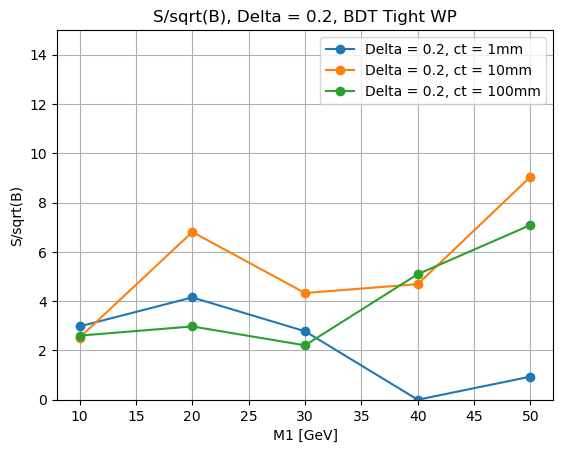

In [493]:
x_arr = [10,20,30,40,50]
y_arr_1 = s_sqrtB['0.2']['ct-1']['tight']
y_arr_2 = s_sqrtB['0.2']['ct-10']['tight']
y_arr_3 = s_sqrtB['0.2']['ct-100']['tight']

plt.plot(x_arr, y_arr_1, '-o', label='Delta = 0.2, ct = 1mm')
plt.plot(x_arr, y_arr_2, '-o', label='Delta = 0.2, ct = 10mm')
plt.plot(x_arr, y_arr_3, '-o', label='Delta = 0.2, ct = 100mm')


plt.legend()

plt.xlabel('M1 [GeV]')
plt.ylabel('S/sqrt(B)')


plt.ylim([0,15])

plt.grid()

plt.title('S/sqrt(B), Delta = 0.2, BDT Tight WP')

Text(0.5, 1.0, 'S/sqrt(B), Delta = 0.1, BDT Medium WP')

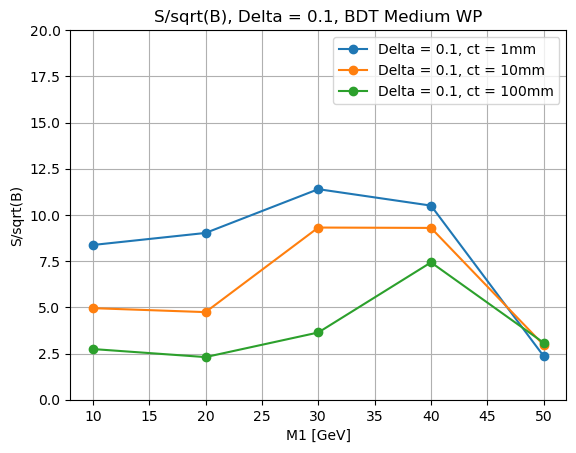

In [491]:
x_arr = [10,20,30,40,50]
y_arr_1 = s_sqrtB['0.1']['ct-1']['medium']
y_arr_2 = s_sqrtB['0.1']['ct-10']['medium']
y_arr_3 = s_sqrtB['0.1']['ct-100']['medium']

plt.plot(x_arr, y_arr_1, '-o', label='Delta = 0.1, ct = 1mm')
plt.plot(x_arr, y_arr_2, '-o', label='Delta = 0.1, ct = 10mm')
plt.plot(x_arr, y_arr_3, '-o', label='Delta = 0.1, ct = 100mm')


plt.legend()

plt.xlabel('M1 [GeV]')
plt.ylabel('S/sqrt(B)')


plt.ylim([0,20])

plt.grid()

plt.title('S/sqrt(B), Delta = 0.1, BDT Medium WP')

Text(0.5, 1.0, 'S/sqrt(B), Delta = 0.2, BDT Medium WP')

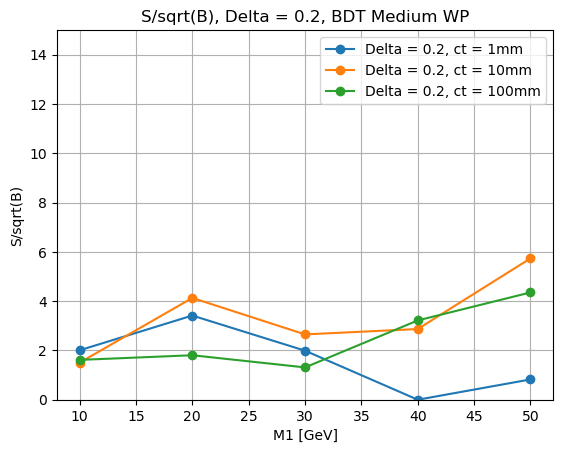

In [495]:
x_arr = [10,20,30,40,50]
y_arr_1 = s_sqrtB['0.2']['ct-1']['medium']
y_arr_2 = s_sqrtB['0.2']['ct-10']['medium']
y_arr_3 = s_sqrtB['0.2']['ct-100']['medium']

plt.plot(x_arr, y_arr_1, '-o', label='Delta = 0.2, ct = 1mm')
plt.plot(x_arr, y_arr_2, '-o', label='Delta = 0.2, ct = 10mm')
plt.plot(x_arr, y_arr_3, '-o', label='Delta = 0.2, ct = 100mm')


plt.legend()

plt.xlabel('M1 [GeV]')
plt.ylabel('S/sqrt(B)')


plt.ylim([0,15])

plt.grid()

plt.title('S/sqrt(B), Delta = 0.2, BDT Medium WP')

Text(0.5, 1.0, 'S/sqrt(B), Delta = 0.1, BDT Loose WP')

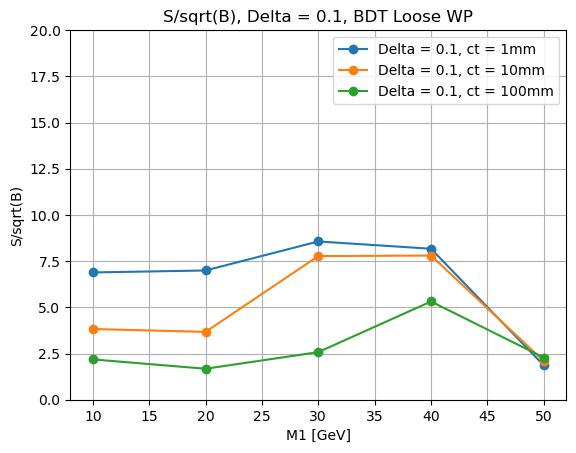

In [496]:
x_arr = [10,20,30,40,50]
y_arr_1 = s_sqrtB['0.1']['ct-1']['loose']
y_arr_2 = s_sqrtB['0.1']['ct-10']['loose']
y_arr_3 = s_sqrtB['0.1']['ct-100']['loose']

plt.plot(x_arr, y_arr_1, '-o', label='Delta = 0.1, ct = 1mm')
plt.plot(x_arr, y_arr_2, '-o', label='Delta = 0.1, ct = 10mm')
plt.plot(x_arr, y_arr_3, '-o', label='Delta = 0.1, ct = 100mm')


plt.legend()

plt.xlabel('M1 [GeV]')
plt.ylabel('S/sqrt(B)')


plt.ylim([0,20])

plt.grid()

plt.title('S/sqrt(B), Delta = 0.1, BDT Loose WP')

Text(0.5, 1.0, 'S/sqrt(B), Delta = 0.2, BDT Loose WP')

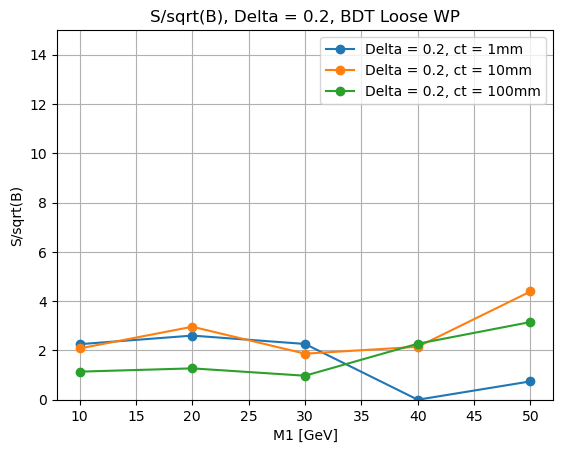

In [497]:
x_arr = [10,20,30,40,50]
y_arr_1 = s_sqrtB['0.2']['ct-1']['loose']
y_arr_2 = s_sqrtB['0.2']['ct-10']['loose']
y_arr_3 = s_sqrtB['0.2']['ct-100']['loose']

plt.plot(x_arr, y_arr_1, '-o', label='Delta = 0.2, ct = 1mm')
plt.plot(x_arr, y_arr_2, '-o', label='Delta = 0.2, ct = 10mm')
plt.plot(x_arr, y_arr_3, '-o', label='Delta = 0.2, ct = 100mm')


plt.legend()

plt.xlabel('M1 [GeV]')
plt.ylabel('S/sqrt(B)')


plt.ylim([0,15])

plt.grid()

plt.title('S/sqrt(B), Delta = 0.2, BDT Loose WP')

Text(0.5, 1.0, 'S/sqrt(B) for ctau = 10mm, BDT Tight WP')

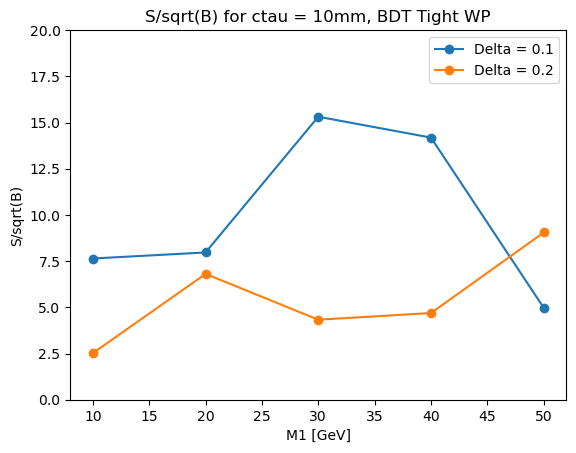

In [476]:
x_arr = [10,20,30,40,50]
y_arr_1 = s_sqrtB['0.1']['ct-10']['tight']
y_arr_2 = s_sqrtB['0.2']['ct-10']['tight']

plt.plot(x_arr, y_arr_1, '-o', label='Delta = 0.1')
plt.plot(x_arr, y_arr_2, '-o', label='Delta = 0.2')

plt.legend()

plt.xlabel('M1 [GeV]')
plt.ylabel('S/sqrt(B)')

plt.ylim([0,20])

plt.title('S/sqrt(B) for ctau = 10mm, BDT Tight WP')

Text(0.5, 1.0, 'S/sqrt(B) for ctau = 100mm, BDT Tight WP')

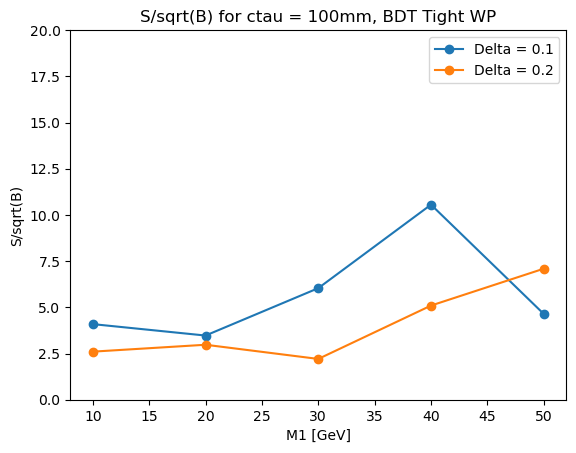

In [477]:
x_arr = [10,20,30,40,50]
y_arr_1 = s_sqrtB['0.1']['ct-100']['tight']
y_arr_2 = s_sqrtB['0.2']['ct-100']['tight']

plt.plot(x_arr, y_arr_1, '-o', label='Delta = 0.1')
plt.plot(x_arr, y_arr_2, '-o', label='Delta = 0.2')

plt.legend()

plt.xlabel('M1 [GeV]')
plt.ylabel('S/sqrt(B)')

plt.ylim([0,20])

plt.title('S/sqrt(B) for ctau = 100mm, BDT Tight WP')

In [504]:
tpr_raw

{'0.1': {'ct-1': {'tight': [0.6012269938650306,
    0.6333333333333333,
    0.6521739130434783,
    0.6199095022624435,
    0.5686274509803921],
   'medium': [0.8159509202453987,
    0.7777777777777778,
    0.8043478260869565,
    0.746606334841629,
    0.7058823529411765],
   'loose': [0.9325153374233128,
    0.9111111111111111,
    0.8913043478260869,
    0.8642533936651584,
    0.8235294117647058]},
  'ct-10': {'tight': [0.7439024390243902,
    0.8831168831168831,
    0.8372093023255814,
    0.7643979057591623,
    0.7755102040816326],
   'medium': [0.8658536585365854,
    0.8961038961038961,
    0.8604651162790697,
    0.837696335078534,
    0.7755102040816326],
   'loose': [0.9512195121951219,
    0.974025974025974,
    0.9651162790697675,
    0.9214659685863874,
    0.8367346938775511]},
  'ct-100': {'tight': [0.7659574468085106,
    0.8387096774193549,
    0.8928571428571429,
    0.8823529411764706,
    0.7142857142857143],
   'medium': [0.9148936170212766,
    0.870967741935483

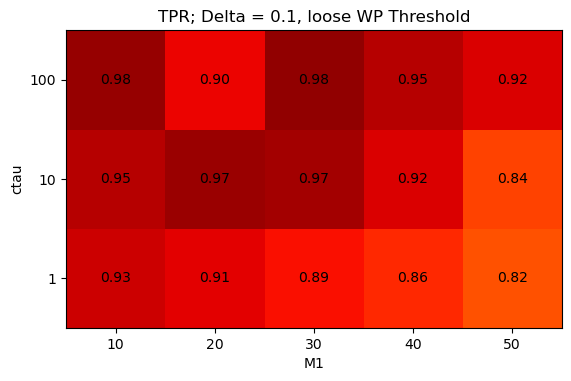

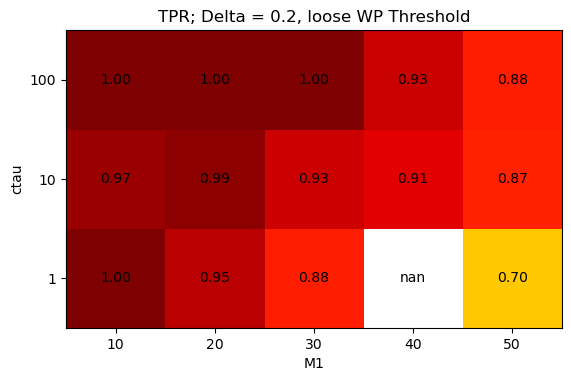

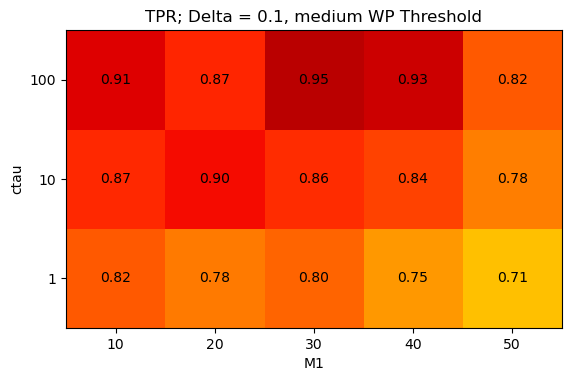

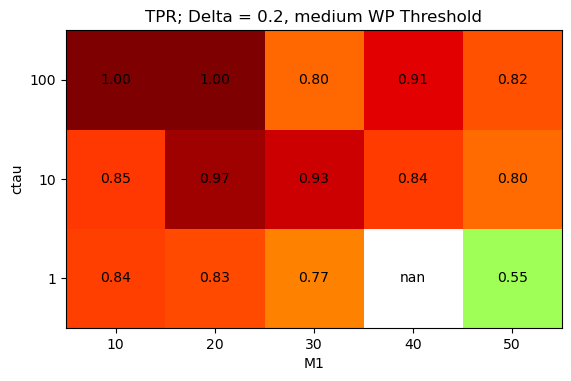

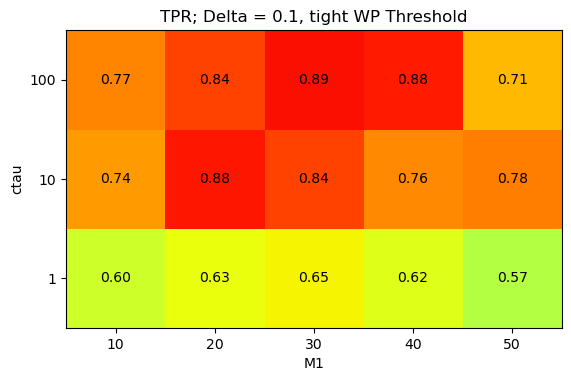

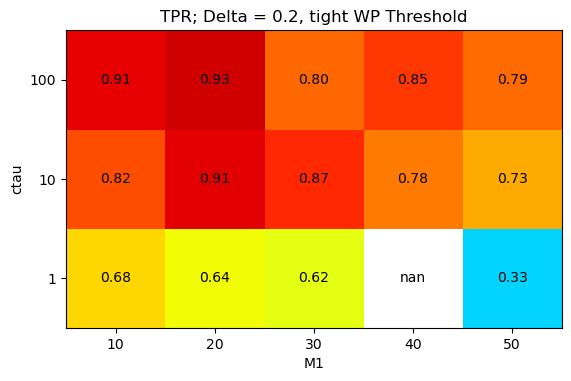

In [507]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([tpr_raw[delta]['ct-1'][wp],\
                        tpr_raw[delta]['ct-10'][wp],\
                        tpr_raw[delta]['ct-100'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=1)
        
        plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'TPR; Delta = {delta}, {wp} WP Threshold')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,5), [10, 20, 30, 40, 50])
        plt.yticks(range(0,3), [1, 10, 100])
        plt.gca().invert_yaxis()
        
        plt.show()

### Pearson Correlation Coefficient

In [ ]:
import pandas as pd

df_bkg = pd.DataFrame(bkg_data, columns = variables)
df_sig = pd.DataFrame(sig_data, columns = variables)
df_all = pd.DataFrame(np.concatenate((bkg_data,sig_data),axis=0), columns = variables)

In [ ]:
corr_all = df_all.corr()
corr_bkg = df_bkg.corr()
corr_sig = df_sig.corr()

In [ ]:
import seaborn as sb
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_all, annot=True, linewidths=.5)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_bkg, annot=True, linewidths=.5)
plt.title(f'PCC in Background Samples (Dataset size: {bkg_data.shape[0]})') # Unweighted by xsec

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_sig, annot=True, linewidths=.5)
plt.title(f'PCC in Signal Samples (Dataset size: {sig_data.shape[0]})')